In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [143]:
prices_df = pd.read_csv("prices_round_1_day_-2.csv", delimiter=";")
trades_df = pd.read_csv("trades_round_1_day_-2.csv", delimiter=";")


In [144]:
prices = prices_df[prices_df["product"]=="SQUID_INK"]['mid_price']

In [129]:
import pandas as pd
import numpy as np

window = 3
prices = pd.Series(prices)  # Assuming prices is already defined

# Calculate rolling mean
mean_price = prices.rolling(window=window).mean()

# Calculate price deviations from the mean (this will have same length as prices)
price_deviations = prices - mean_price

# Calculate price changes (this will be 1 element shorter than prices)
price_changes = prices.diff()  # Using pandas diff instead of numpy diff

# Now we need to align the indices
# Only consider points where both series have valid values
valid_indices = ~(mean_price.isna() | price_changes.isna())

# Apply the valid indices to both series
valid_deviations = price_deviations[valid_indices]
valid_changes = price_changes[valid_indices]

# Calculate covariance and variance
covariance = np.cov(valid_deviations, valid_changes)[0, 1]
variance = np.var(valid_deviations)

# Calculate reversion beta
reversion_beta = covariance / variance
print(f"Reversion Beta: {reversion_beta}")

Reversion Beta: 1.2904197989301036


In [111]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [130]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson

# Short window analysis (example for 5-day window)
window = 5
prices = pd.Series(prices)

# 1. Autocorrelation approach
returns = prices.pct_change().dropna()
lag1_autocorr = returns.autocorr(lag=17)
print(f"Lag-1 Autocorrelation: {lag1_autocorr}")
# Interpretation: negative = mean reversion, positive = momentum

# 2. Modified reversion metric using residuals
mean_price = prices.rolling(window=window).mean()
deviations = prices - mean_price
next_day_move = deviations.shift(-1) - deviations
valid_indices = ~(deviations.isna() | next_day_move.isna())

# Calculate direction alignment (how often price moves toward vs. away from mean)
direction_toward_mean = np.sign(deviations[valid_indices]) != np.sign(next_day_move[valid_indices])
reversion_frequency = direction_toward_mean.mean()
print(f"Reversion Frequency: {reversion_frequency}")
# Above 0.5 suggests mean reversion, below 0.5 suggests momentum

# 3. Durbin-Watson test (close to 0 = positive serial correlation, close to 4 = negative correlation)
dw_stat = durbin_watson(returns.values[-window:])
print(f"Durbin-Watson stat: {dw_stat}")

Lag-1 Autocorrelation: -0.006821738190335556
Reversion Frequency: 0.7210605302651326
Durbin-Watson stat: 0.4126980564025233


In [53]:
m1 = 0
m2 = 0
for lag in range(3000,4000):
    lag1_autocorr = returns.autocorr(lag=lag)
    m1 = max(m1, lag1_autocorr)
    m2 = min(m2, lag1_autocorr)

In [54]:
print(m1, m2)

0.07905007878243418 -0.08283742227869816


In [131]:
from statsmodels.tsa.stattools import adfuller

def adf_test(price_series):
    result = adfuller(price_series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    # p-value < 0.05 suggests mean reversion (stationary series)
    
def calculate_half_life(price_series):
    # Calculate returns
    delta = price_series.diff().dropna()
    # Lag price levels
    lag = price_series.shift(1).dropna()
    # Match delta and lag lengths
    delta = delta[1:]
    lag = lag[1:]
    # Linear regression: delta ~ lag
    beta = np.cov(delta, lag)[0,1] / np.var(lag)
    half_life = -np.log(2) / beta
    return half_life if half_life > 0 else np.nan

from scipy import signal
import matplotlib.pyplot as plt

def spectral_analysis(series, sampling_freq=1):
    # Detrend the data
    detrended = signal.detrend(series)
    # Apply Fourier transform
    f, Pxx = signal.periodogram(detrended, sampling_freq)
    # Find peak frequencies (excluding zero frequency)
    non_zero_mask = f > 0
    peak_idx = np.argmax(Pxx[non_zero_mask])
    peak_freq = f[non_zero_mask][peak_idx]
    peak_period = 1/peak_freq if peak_freq > 0 else float('inf')
    
    plt.figure(figsize=(10, 6))
    plt.plot(f, Pxx)
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Power Spectral Density')
    plt.title('Spectral Analysis for Cyclical Patterns')
    plt.axvline(peak_freq, color='r', linestyle='--')
    plt.annotate(f'Peak Period: {peak_period:.2f} days', 
                xy=(peak_freq, Pxx[non_zero_mask][peak_idx]),
                xytext=(peak_freq*1.1, Pxx[non_zero_mask][peak_idx]*0.9))
    plt.show()
    
    return peak_period

from statsmodels.graphics.tsaplots import plot_acf

def acf_analysis(returns, max_lags=9999):
    # Plot ACF 
    plt.figure(figsize=(12, 6))
    plot_acf(returns, lags=max_lags)
    plt.title('Autocorrelation Function')
    plt.show()
    
    # Calculate ACF values
    acf_values = [returns.autocorr(lag=i) for i in range(1, max_lags+1)]
    
    # Find peaks in ACF
    peaks = signal.find_peaks(acf_values)[0]
    if len(peaks) > 0:
        print(f"Potential cycles at lags: {peaks + 1}")
        # Time between peaks suggests cycle length
        if len(peaks) > 1:
            avg_cycle = np.mean(np.diff(peaks))
            print(f"Average cycle length: {avg_cycle:.2f} periods")
    else:
        print("No clear cyclical pattern detected")

<Figure size 1200x600 with 0 Axes>

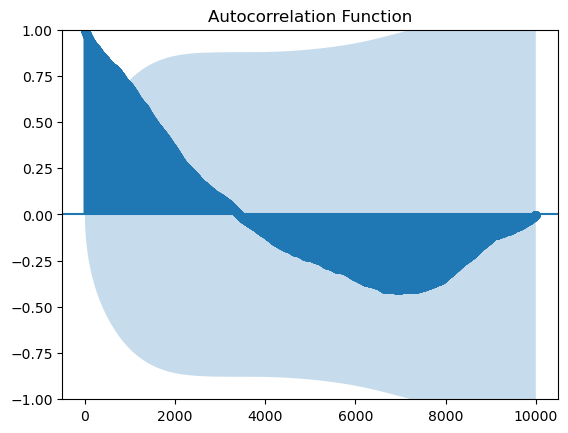

Potential cycles at lags: [1595 1601 1603 1606 1624 1626 1628 1643 1647 1659 1664 1766 1769 1777
 1788 1796 1798 1910 1913 2166 2210 2252 2263 2268 2271 2275 2278 2319
 2321 2325 2374 2428 2442 2444 2455 2459 2461 2464 2500 2503 2507 2510
 2534 2536 2539 2546 2552 2558 2598 2603 2605 2634 2636 2638 2666 2671
 2710 2792 2802 2805 2807 2809 2881 3065 3076 3082 3086 3096 3099 3102
 3122 3174 3176 3183 3185 3188 3552 3594 3699 3703 3716 3724 3726 3763
 3768 3774 3776 3948 3959 3963 3997 4003 4018 4021 4254 4257 4259 4278
 4280 4282 4285 4546 4824 4830 4838 5073 5078 5150 5160 5408 5449 5451
 5485 5606 5677 5685 5743 5757 6704 6709 6714 6731 6733 6776 6836 6974
 6982 6987 6991 6998 7080 7082 7085 7087 7094 7120 7122 7141 7150 7172
 7182 7189 7193 7225 7243 7313 7365 7367 7382 7385 7406 7449 7454 7483
 7485 7490 7496 7501 7554 7557 7559 7562 7580 7582 7616 7621 7623 7626
 7641 7644 7654 7658 7736 7739 7747 7751 7755 7757 7789 7792 7820 7822
 7982 7984 7986 7988 7990 8065 8084 8182 8184 8215 

C:\Users\tzs7ch\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\tzs7ch\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [132]:
acf_analysis(prices)

In [133]:
def find_optimal_lookback(price_series, max_lookback=50):
    results = {}
    for lookback in range(2, max_lookback+1):
        mean_price = price_series.rolling(window=lookback).mean()
        # Calculate price deviations
        deviations = price_series - mean_price
        deviations = deviations.dropna()
        # Calculate future returns
        future_return = price_series.pct_change(1).shift(-1).dropna()
        # Align the series
        common_idx = deviations.index.intersection(future_return.index)
        if len(common_idx) > lookback:
            deviations = deviations.loc[common_idx]
            future_return = future_return.loc[common_idx]
            # Calculate correlation
            correlation = deviations.corr(future_return)
            # Calculate success rate
            success = ((deviations < 0) & (future_return > 0)) | ((deviations > 0) & (future_return < 0))
            success_rate = success.mean()
            results[lookback] = {
                'correlation': correlation,
                'success_rate': success_rate
            }
    
    # Find optimal lookback
    lookbacks = list(results.keys())
    correlations = [results[lb]['correlation'] for lb in lookbacks]
    success_rates = [results[lb]['success_rate'] for lb in lookbacks]
    
    # Plot results
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(lookbacks, correlations, 'b-', label='Correlation')
    ax1.set_xlabel('Lookback Period')
    ax1.set_ylabel('Correlation', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot(lookbacks, success_rates, 'r-', label='Success Rate')
    ax2.set_ylabel('Success Rate', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title('Optimal Lookback Period Analysis')
    plt.grid(True)
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.show()
    
    # Return optimal lookback
    best_lookback = lookbacks[np.argmin(correlations)]
    return best_lookback, results

In [134]:
def beta_stability(price_series, window=30, test_periods=10):
    betas = []
    dates = []
    
    for i in range(len(price_series) - window - test_periods):
        subset = price_series.iloc[i:i+window+test_periods]
        mean_price = subset.rolling(window=window).mean()
        deviations = subset - mean_price
        price_changes = subset.diff()
        
        # Align indices
        valid = ~(deviations.isna() | price_changes.isna())
        valid_deviations = deviations[valid]
        valid_changes = price_changes[valid]
        
        if len(valid_deviations) > 5:  # Ensure enough data
            cov_matrix = np.cov(valid_deviations, valid_changes)
            if cov_matrix.shape == (2, 2):  # Ensure valid covariance matrix
                covariance = cov_matrix[0, 1]
                variance = np.var(valid_deviations)
                if variance > 0:  # Avoid division by zero
                    beta = covariance / variance
                    betas.append(beta)
                    dates.append(price_series.index[i+window])
    
    beta_series = pd.Series(betas, index=dates)
    
    # Plot beta stability
    plt.figure(figsize=(12, 6))
    plt.plot(beta_series)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Mean Reversion Beta Stability Over Time')
    plt.xlabel('Date')
    plt.ylabel('Beta Value')
    plt.grid(True)
    plt.show()
    
    # Calculate stability metrics
    stability = {
        'mean_beta': beta_series.mean(), 
        'std_beta': beta_series.std(),
        'stable_periods': (beta_series < 0).mean()  # Fraction of periods with mean reversion
    }
    
    return beta_series, stability

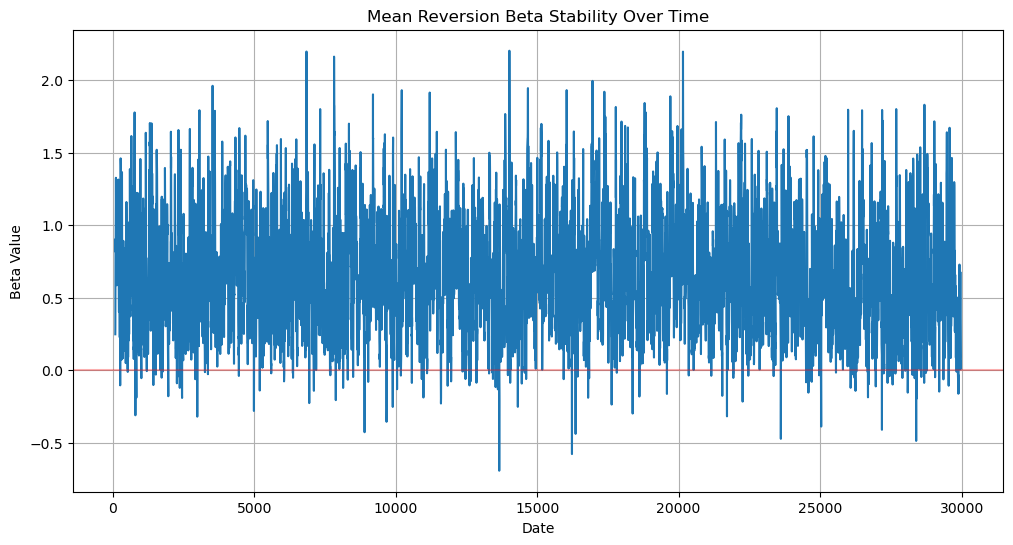

(91       0.247522
93       0.292993
98       0.798998
100      0.905199
103      0.815384
           ...   
29956    0.060680
29959    0.020597
29961    0.006273
29966    0.097535
29968    0.671112
Length: 9960, dtype: float64, {'mean_beta': 0.6386205196143805, 'std_beta': 0.3820907355805246, 'stable_periods': 0.019076305220883535})


In [135]:
print(beta_stability(prices))

In [136]:
from hmmlearn import hmm
import numpy as np

def detect_market_regimes(returns, n_regimes=5):
    # Reshape returns for HMM
    X = np.column_stack([returns])
    
    # Create and train HMM
    model = hmm.GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=1000)
    model.fit(X)
    
    # Predict hidden states
    hidden_states = model.predict(X)
    
    # Calculate mean and variance for each regime
    regime_stats = {}
    for i in range(n_regimes):
        mask = (hidden_states == i)
        regime_stats[i] = {
            'mean': returns[mask].mean(),
            'variance': returns[mask].var(),
            'frequency': mask.mean()
        }
    
    # Determine if any regime shows mean reversion
    for i, stats in regime_stats.items():
        # Calculate lag-1 autocorrelation in this regime
        regime_returns = returns[hidden_states == i]
        if len(regime_returns) > 1:
            autocorr = pd.Series(regime_returns).autocorr(lag=1)
            regime_stats[i]['autocorrelation'] = autocorr
            regime_stats[i]['shows_mean_reversion'] = autocorr < -0.1
    
    return hidden_states, regime_stats

In [137]:
detect_market_regimes(prices)

(array([3, 0, 3, ..., 1, 1, 1], dtype=int64),
 {0: {'mean': 1935.9522162841874,
   'variance': 450.556521029936,
   'frequency': 0.3181,
   'autocorrelation': 0.9970722870382932,
   'shows_mean_reversion': False},
  1: {'mean': 1858.607732526142,
   'variance': 408.08149538013083,
   'frequency': 0.3634,
   'autocorrelation': 0.9977790767008989,
   'shows_mean_reversion': False},
  2: {'mean': 1894.5, 'variance': nan, 'frequency': 0.0001},
  3: {'mean': 1935.9820811065701,
   'variance': 452.0878863594574,
   'frequency': 0.3181,
   'autocorrelation': 0.9972415920081316,
   'shows_mean_reversion': False},
  4: {'mean': 1896.1666666666667,
   'variance': 0.33333333333333337,
   'frequency': 0.0003,
   'autocorrelation': nan,
   'shows_mean_reversion': False}})

In [138]:
def calculate_hurst_exponent(time_series, max_lag=20):
    """
    Calculate the Hurst exponent of a time series
    H < 0.5: mean-reverting series
    H = 0.5: random walk
    H > 0.5: trending series
    """
    lags = range(2, max_lag)
    tau = []; 
    
    # Calculate the array of the variances of the lagged differences
    for lag in lags:
        # Calculate price difference with lag
        pp = np.subtract(time_series[lag:].values, time_series[:-lag].values)
        # Calculate variance of difference
        tau.append(np.sqrt(np.std(pp)))
    
    # Calculate the slope of the log plot (the Hurst exponent)
    m = np.polyfit(np.log10(lags), np.log10(tau), 1)
    hurst = m[0]
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(np.log10(lags), np.log10(tau), 'o')
    plt.plot(np.log10(lags), m[0]*np.log10(lags) + m[1], 'r')
    plt.title(f'Hurst Exponent: {hurst:.4f}')
    plt.xlabel('Log10(Lag)')
    plt.ylabel('Log10(Standard Deviation)')
    plt.grid(True)
    plt.show()
    
    return hurst

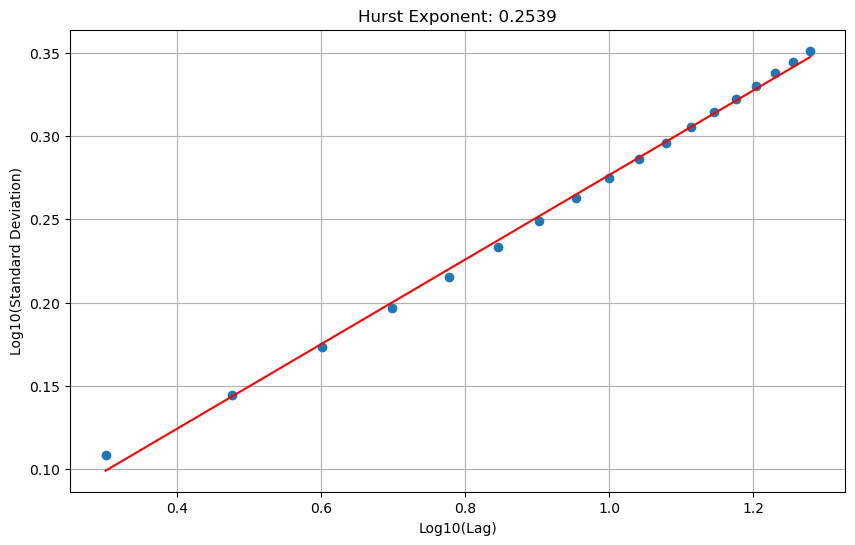

0.25394876140700534

In [139]:
calculate_hurst_exponent(prices)

In [140]:
def run_comprehensive_analysis(price_series, short_window=10):
    """
    Comprehensive analysis for short-term patterns
    """
    results = {}
    
    # 1. Basic statistics
    returns = price_series.pct_change().dropna()
    results['mean_return'] = returns.mean()
    results['volatility'] = returns.std()
    
    # 2. Autocorrelation test
    results['autocorr_lag1'] = returns.autocorr(lag=1)
    results['autocorr_lag2'] = returns.autocorr(lag=2)
    
    # 3. Modified reversion metric for short window
    mean_price = price_series.rolling(window=short_window).mean()
    deviations = price_series - mean_price
    next_day_move = deviations.shift(-1) - deviations
    valid_indices = ~(deviations.isna() | next_day_move.isna())
    direction_toward_mean = np.sign(deviations[valid_indices]) != np.sign(next_day_move[valid_indices])
    results['reversion_frequency'] = direction_toward_mean.mean()
    
    # 4. Estimate reversion beta despite short window
    if len(valid_indices) > short_window:
        valid_dev = deviations[valid_indices]
        valid_change = next_day_move[valid_indices] 
        covar = np.cov(valid_dev, valid_change)[0,1]
        var_dev = np.var(valid_dev)
        results['reversion_beta'] = covar / var_dev if var_dev > 0 else np.nan
    else:
        results['reversion_beta'] = np.nan
    
    # 5. Detect cycles within short period
    if len(returns) >= 2*short_window:
        from scipy import signal
        f, pxx = signal.periodogram(returns.dropna(), fs=1)
        dominant_period = 1/f[np.argmax(pxx[1:])+1] if len(f) > 1 else np.nan
        results['dominant_period'] = dominant_period
    else:
        results['dominant_period'] = np.nan
    
    # 6. Quick ADF test if enough data
    if len(price_series) >= 2*short_window:
        try:
            adf_result = adfuller(price_series)
            results['adf_pvalue'] = adf_result[1]
            results['stationary'] = adf_result[1] < 0.05
        except:
            results['adf_pvalue'] = np.nan
            results['stationary'] = False
    
    # 7. Hurst exponent scaled for short window
    if len(price_series) >= 3*short_window:
        max_lag = min(short_window, len(price_series)//3)
        if max_lag >= 4:  # Need at least a few lags
            try:
                results['hurst'] = calculate_hurst_exponent(price_series, max_lag=max_lag)
            except:
                results['hurst'] = np.nan
    
    # 8. Simple analysis summary
    if results['autocorr_lag1'] < -0.1:
        pattern = "Mean reverting"
    elif results['autocorr_lag1'] > 0.1:
        pattern = "Momentum"
    else:
        pattern = "Random walk"
    
    if not np.isnan(results.get('hurst', np.nan)):
        if results['hurst'] < 0.4:
            pattern += " (strongly mean-reverting)"
        elif results['hurst'] > 0.6:
            pattern += " (strongly trending)"
    
    results['pattern_summary'] = pattern
    
    return results

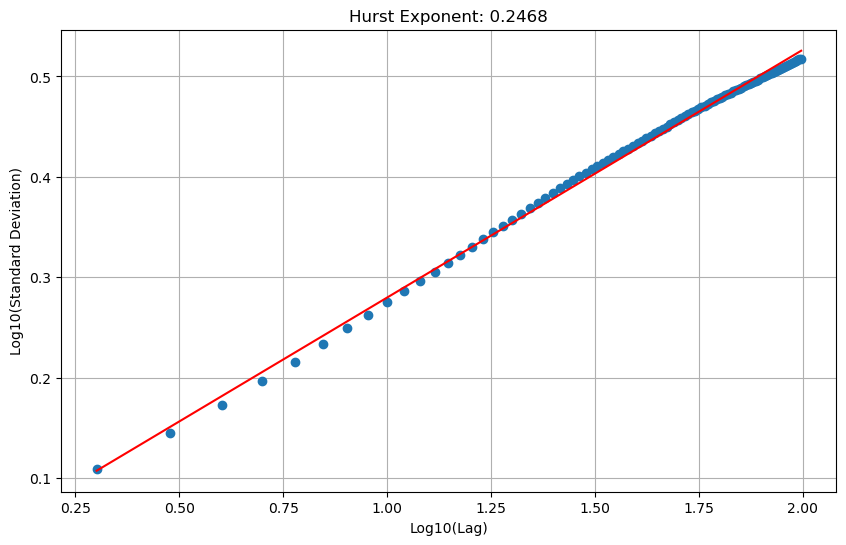

{'mean_return': -6.59292315302255e-06,
 'volatility': 0.0006875032110859584,
 'autocorr_lag1': -0.20721712647652163,
 'autocorr_lag2': 0.020982981294964027,
 'reversion_frequency': 0.5945454545454546,
 'reversion_beta': -0.020451997331516914,
 'dominant_period': 2.314583333333333,
 'adf_pvalue': 0.6440013533668795,
 'stationary': False,
 'hurst': 0.2468274750915585,
 'pattern_summary': 'Mean reverting (strongly mean-reverting)'}

In [141]:
run_comprehensive_analysis(prices, short_window = 100)

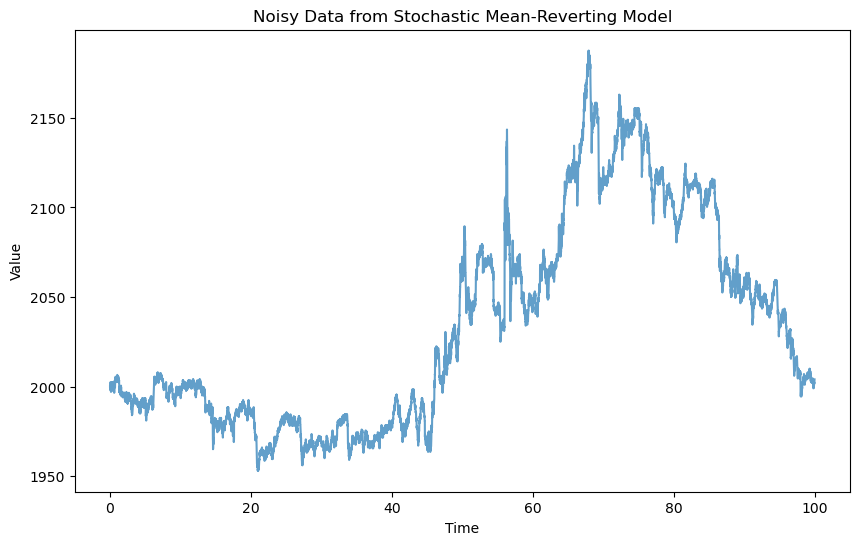

Fitted Parameters:
X0: 49.999999992287755, Theta: 0.19999991624055677, Mu: 49.999999958952664, Sigma: 2.00000001858374, Beta: 5.000000055326507, Omega: 0.09999998406264748


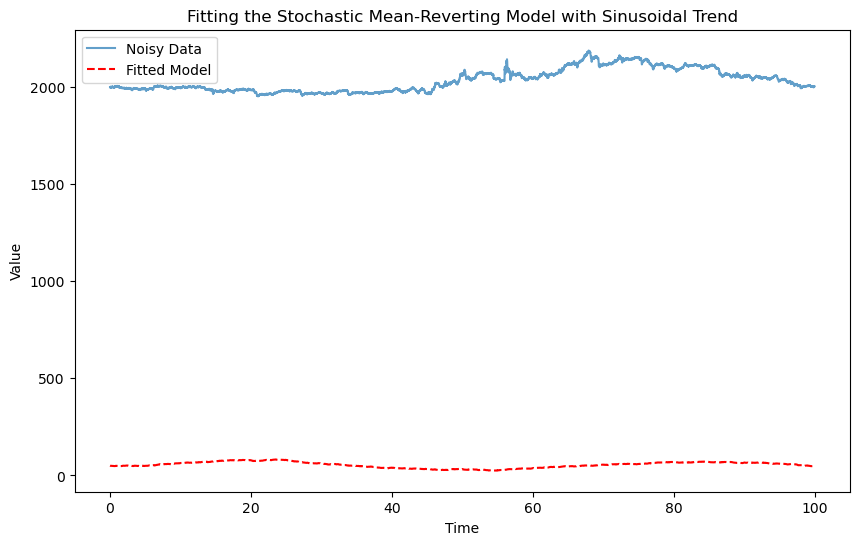

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

# Define the model: Mean-Reverting Process with a Sinusoidal Trend
def mean_reverting_sin_model(t, X0, theta, mu, sigma, beta, omega):
    """
    Stochastic process model: Mean reversion with sinusoidal trend.
    
    t: Time array (n_time_steps,)
    X0: Initial value of the process
    theta: Mean reversion speed
    mu: Long-term mean
    sigma: Volatility (noise term)
    beta: Amplitude of the sinusoidal term
    omega: Frequency of the sinusoidal term
    """
    dt = np.diff(t)[0]  # Assuming uniform time steps
    X = np.zeros_like(t)
    X[0] = X0

    # Simulate the process over time
    for i in range(1, len(t)):
        dW = np.random.normal(0, np.sqrt(dt))  # Brownian motion
        dX = theta * (mu - X[i-1]) * dt + sigma * dW + beta * np.sin(omega * t[i]) * dt
        X[i] = X[i-1] + dX
    
    return X

# Generate synthetic data (for testing the fitting)
np.random.seed(42)
n_time_steps = 10000
time_steps = np.linspace(0, 100, n_time_steps)
X_true = mean_reverting_sin_model(time_steps, X0=50, theta=0.2, mu=50, sigma=2, beta=5, omega=0.1)
noise = np.random.normal(0, 1, size=n_time_steps)
data = prices.copy(deep = True)

# Plot the synthetic data
plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label="Noisy Data", alpha=0.7)
plt.title("Noisy Data from Stochastic Mean-Reverting Model")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Define the loss function for parameter fitting
def loss_function(params, t, data):
    X0, theta, mu, sigma, beta, omega = params
    model_data = mean_reverting_sin_model(t, X0, theta, mu, sigma, beta, omega)
    return np.sum((model_data - data)**2)  # Sum of squared errors

# Initial guesses for the parameters
initial_guess = [50, 0.2, 50, 2, 5, 0.1]

# Fit the model to the noisy data using minimize
result = minimize(loss_function, initial_guess, args=(time_steps, data), method='L-BFGS-B', bounds=[(None, None), (0, None), (None, None), (0, None), (None, None), (0, None)])

# Extract the fitted parameters
fitted_params = result.x
X0_fitted, theta_fitted, mu_fitted, sigma_fitted, beta_fitted, omega_fitted = fitted_params

# Print the fitted parameters
print(f"Fitted Parameters:")
print(f"X0: {X0_fitted}, Theta: {theta_fitted}, Mu: {mu_fitted}, Sigma: {sigma_fitted}, Beta: {beta_fitted}, Omega: {omega_fitted}")

# Plot the fitted model against the noisy data
fitted_data = mean_reverting_sin_model(time_steps, X0_fitted, theta_fitted, mu_fitted, sigma_fitted, beta_fitted, omega_fitted)

plt.figure(figsize=(10, 6))
plt.plot(time_steps, data, label="Noisy Data", alpha=0.7)
plt.plot(time_steps, fitted_data, label="Fitted Model", linestyle='--', color='red')
plt.title("Fitting the Stochastic Mean-Reverting Model with Sinusoidal Trend")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()
